In [1]:
#!pip3 install git+https://github.com/qiskit-community/qiskit-textbook.git#subdirectory=qiskit-textbook-src
#!pip3 install pylatexenc

In [2]:
import qiskit
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, AncillaRegister, execute, Aer
from qiskit.visualization import plot_histogram
from qiskit.aqua.components.oracles import TruthTableOracle
from qiskit.extensions.unitary import unitary
import matplotlib.pyplot as plt

In [3]:
def exec_circuit(circuit, backend=Aer.get_backend('qasm_simulator')):
    res = execute(circuit, backend).result()
    return res, res.get_counts()

def init_circuit(circuit, init_state=None, target_qubits=None):
    '''
    Initialize the circuit with the init_state applied to the
    target_quibts
    '''
    if init_state != None and target_qubits != None:
        circuit.initialize(init_state, target_qubits)

def run_on_inputs(fn_create_circuit, n, input_qubits=None):
    '''
    :param n: the number of qubits
    :param fn_create_circuit: a function to create a circuit
    :return: the run of the circuits on all possible inputs
    '''
    N = pow(2, n)
    if input_qubits == None:
        input_qubits = list(range(0, n))
    assert n == len(input_qubits), "The number of qubits and its labels need to match"
    f, ax = plt.subplots(N, figsize=(10,15))
    f.subplots_adjust(wspace=0.9)
    f.tight_layout(pad=3)
    for i in range(0,N):
        s = [0] * N
        s[i] = 1
        circ = fn_create_circuit(s, input_qubits)
        res, cts = exec_circuit(circ)
        ax[i].set_title(f'Case {s}')
        plot_histogram(cts, ax=ax[i])

### Simple circuit to calculate sum mod 2

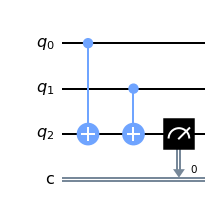

In [4]:
def create_adder(init_state=None, qbits=None):
    n_q = 3
    n_m = 1
    circ = QuantumCircuit(n_q,n_m)
    init_circuit(circ, init_state, qbits)
    circ.cnot(0,2)
    circ.cnot(1,2)
    circ.measure(2,0)
    return circ
circ = create_adder()
circ.draw()

### Now run the circuit on all possible inputs
That is 00,01,10,11. The circuit calculates $$ (x_1 + x_2) mod $$ 2.
Bear in mind that the inputs is the tensor of $$q_0$$ and $$q_1$$. So 00 = $$\pmatrix{1\\0\\0\\0} $$

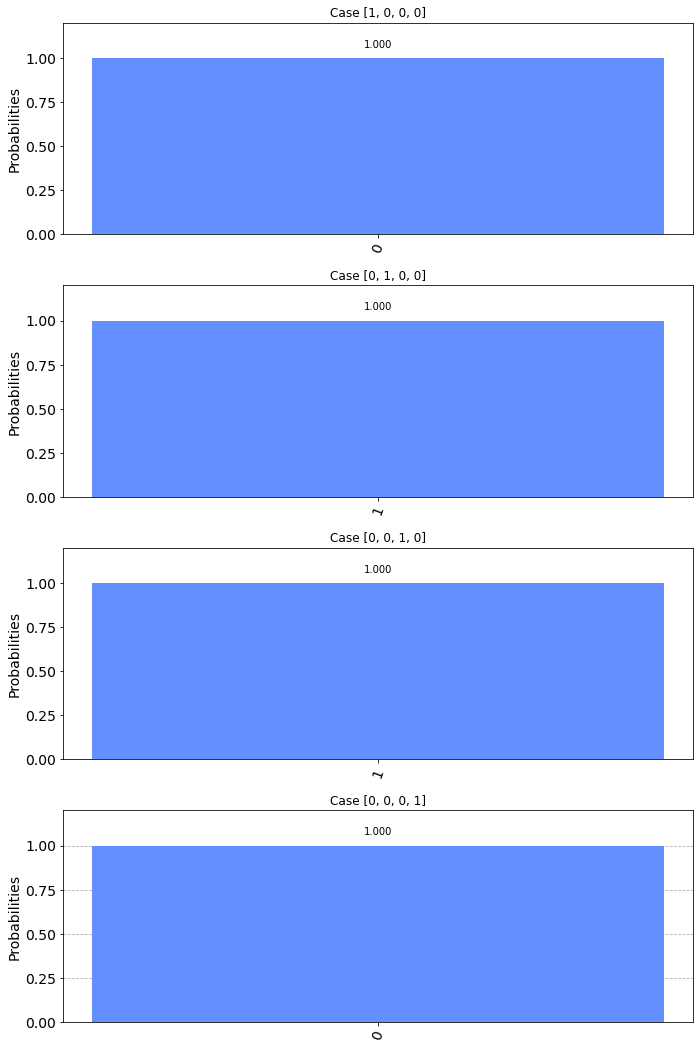

In [5]:
run_on_inputs(create_adder, 2)

## Let us do an indirect measurement circuit
The below circuit allows to measure the top qubit, and with that inspect the value of the bottom qubit.
The final state of this circuit is of the form
$$ a|00> + b|00> $$
Where $ a|0> + b|0> $ is the bottom qubit.

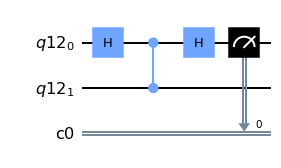

In [6]:
def create_indirect_measure(init_state=None, target_init_qubits=None):
    n = 2
    reg = QuantumRegister(n)
    creg = ClassicalRegister(1)
    circ = QuantumCircuit(reg, creg)
    init_circuit(circ, init_state, target_init_qubits)
    circ.h(0)
    circ.cz(0,1)
    circ.h(0)
    circ.measure(0,0)
    return circ
circ = create_indirect_measure()
circ.draw()

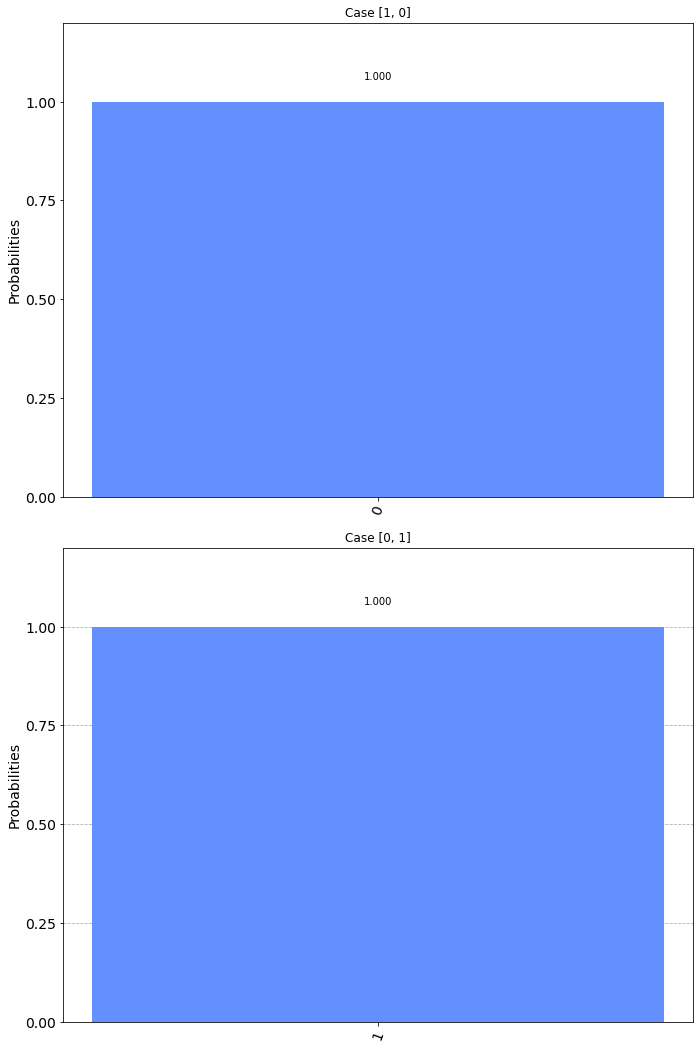

In [7]:
run_on_inputs(create_indirect_measure, 1)

Let us examine a different circuit now which encodes a phase quickback to find an answer.
Let us suppose we have an oracle O that given an index i returns the value of bit at the i-th location for
a string x.

The top qubit register is a register of n qubits where n is the length of x. We will name that register $ s $
If $ s_i $ is 1 then the oracle outputs $ s_i * x_i $.

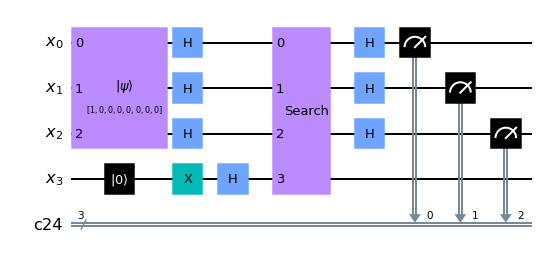

In [45]:
def oracle_for_string(s):
    '''
    This circuit implements the mod 2 sum of x_i * s_i, for a fixed string s = "101"
    :param s:
    :return:
    '''
    n = len(s) + 1
    circ = QuantumCircuit(n)
    circ.cx(0,3)
    circ.cx(2,3)
    return circ

n = 4
def bit_search(init_state=None, target_init_qubits=None):
    reg = QuantumRegister(n,"x")
    creg = ClassicalRegister(n - 1)
    circ=QuantumCircuit(reg, creg)
    init_circuit(circ, init_state, target_init_qubits)
    circ.reset(n - 1)
    circ.x(n - 1)
    circ.h(range(n))
    orc = oracle_for_string("101").to_gate(label="search")
    circ.append(orc, range(n))
    circ.h(range(n - 1))
    for i in range(n -1):
        circ.measure(i, i)
    return circ

#circ = bit_search()
circ = bit_search([1, 0, 0, 0, 0, 0, 0, 0], [0,1,2])
circ.draw()

Now running the circuit and measuring the top register, we will recover the initial string x

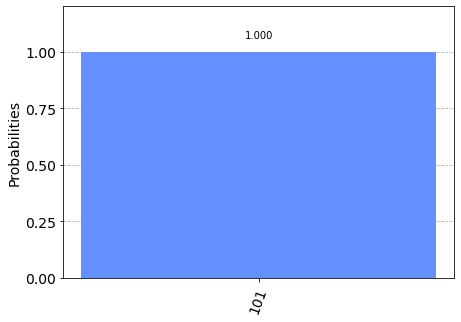

In [46]:
res, cts = exec_circuit(circ)
plot_histogram(cts)






